<a href="https://colab.research.google.com/github/fvelezo/fvelezo.github.io/blob/master/Copia_de_Borrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Instalación de librerías e imports 





In [ ]:
pip install sodapy

In [ ]:
pip install pandas

In [ ]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import plugins
from sodapy import Socrata
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score


plt.rcParams['figure.figsize']=10,12

import warnings

warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# 2. Carga automática de datos públicos

In [ ]:
client = Socrata("www.datos.gov.co", None)
results = client.get("gt2j-8ykr", limit = 1000000)
df_results = pd.DataFrame.from_records(results)


# 3. Renombramiento de columnas y parámetros

In [ ]:
ciudades = ["Bogotá D.C.", "Medellín", "Cali", "Barranquilla", "Bucaramanga", 
      "Cartagena de Indias", "Pereira", "Manizales", "Ibagué", "Santa Marta"]

df_covid_crudos = df_results.copy().loc[df_results['ciudad_de_ubicaci_n']
.isin(ciudades)]
def estado_atencion(row):
    if row['atenci_n'] == 'Recuperado':
        est = 'Recuperado' 
    elif row['atenci_n'] in ['Casa', 'CASA', 'Hospital', 'Hospital UCI', 'N/A']:
        est = 'Caso actual'
    elif row['atenci_n'] == 'Fallecido':
        est = 'Fallecido'
    else:
      est = 'Unknown'
    return est

df_covid_crudos['estado_atencion'] = df_covid_crudos.apply(estado_atencion, axis=1)

In [ ]:
df_covid_one_hot = pd.get_dummies(df_covid_crudos['estado_atencion'])
df_covid_one_hot

,Caso actual,Fallecido,Recuperado
0,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
6,0,0,1
...,...,...,...
590515,1,0,0
590516,1,0,0
590517,1,0,0
590518,1,0,0


In [ ]:
df_covid_crudos = df_covid_crudos.drop('estado_atencion', axis = 1)
df_covid_crudos = df_covid_crudos.join(df_covid_one_hot)
df_covid_crudos

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte,Caso actual,Fallecido,Recuperado
0,1,2020-03-02T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06T00:00:00.000,2020-03-13T00:00:00.000,2020-03-06T00:00:00.000,PCR,11,380,Otro,NaN,NaN,0,0,1
2,3,2020-03-07T00:00:00.000,05001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29T00:00:00.000,2020-03-09T00:00:00.000,2020-03-15T00:00:00.000,2020-03-09T00:00:00.000,PCR,5,724,Otro,NaN,NaN,0,0,1
3,4,2020-03-09T00:00:00.000,05001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06T00:00:00.000,2020-03-11T00:00:00.000,2020-03-26T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaN,0,0,1
4,5,2020-03-09T00:00:00.000,05001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08T00:00:00.000,2020-03-11T00:00:00.000,2020-03-23T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaN,0,0,1
6,7,2020-03-08T00:00:00.000,13001,Cartagena de Indias,Cartagena D.T. y C.,Recuperado,85,F,Importado,Leve,ESTADOS UNIDOS,2020-03-02T00:00:00.000,2020-03-11T00:00:00.000,2020-03-17T00:00:00.000,2020-03-11T00:00:00.000,PCR,13,840,Otro,NaN,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590515,590556,2020-08-13T00:00:00.000,05001,Medellín,Antioquia,Casa,18,M,En estudio,Leve,NaN,2020-08-09T02:17:14.254,2020-08-24T00:00:00.000,NaN,2020-08-28T00:00:00.000,NaN,5,NaN,NaN,NaN,NaN,1,0,0
590516,590557,2020-08-01T00:00:00.000,05001,Medellín,Antioquia,Casa,20,M,En estudio,Leve,NaN,2020-07-28T02:17:14.254,2020-08-12T00:00:00.000,NaN,2020-08-28T00:00:00.000,NaN,5,NaN,NaN,NaN,NaN,1,0,0
590517,590558,2020-07-30T00:00:00.000,05001,Medellín,Antioquia,Casa,17,F,En estudio,Leve,NaN,2020-07-26T02:17:14.254,2020-08-10T00:00:00.000,NaN,2020-08-28T00:00:00.000,NaN,5,NaN,NaN,NaN,NaN,1,0,0
590518,590559,2020-08-14T00:00:00.000,05001,Medellín,Antioquia,Casa,18,F,En estudio,Leve,NaN,2020-08-10T02:17:14.254,2020-08-25T00:00:00.000,NaN,2020-08-28T00:00:00.000,NaN,5,NaN,NaN,NaN,NaN,1,0,0


In [ ]:
# Conversión de objetos a fechas

#df_covid_crudos = df_results.copy()

df_covid_crudos['fecha_diagnostico'] =  pd.to_datetime(df_covid_crudos
                                                    ['fecha_diagnostico'])
df_covid_crudos['fecha_recuperado'] =  pd.to_datetime(df_covid_crudos
                                                    ['fecha_recuperado'])
df_covid_crudos['fecha_reporte_web'] =  pd.to_datetime(df_covid_crudos
                                                    ['fecha_reporte_web'])
df_covid_crudos['fecha_de_muerte'] =  pd.to_datetime(df_covid_crudos
                                                    ['fecha_de_muerte'])

In [ ]:
#Conteo de casos

# Toda Colombia
df_covid_col_rep = df_covid_crudos.groupby('fecha_reporte_web').agg({'id_de_caso':'count',
                                                                     'Recuperado':'sum',
                                                                     'Caso actual':'sum',
                                                                     'Fallecido':'sum'})
df_covid_col_rep.reset_index(inplace=True)
df_covid_col_rep.rename(columns={'id_de_caso':'conteo_casos',
                                 'Recuperado':'recuperado',
                                 'Caso actual':'caso_actual',
                                 'Fallecido':'fallecido'}, inplace=True)

#df_covid.loc[df_covid['atenci_n'] == 'N/A']
# Bogotá
df_covid_bog_rep = df_covid_crudos.loc[df_covid_crudos['ciudad_de_ubicaci_n'] == 'Bogotá D.C.'].groupby('fecha_reporte_web').agg({'id_de_caso':'count',
                                                                                                                                  'Recuperado':'sum',
                                                                                                                                  'Caso actual':'sum',
                                                                                                                                  'Fallecido':'sum'})
df_covid_bog_rep.reset_index(inplace=True)
df_covid_bog_rep.rename(columns={'id_de_caso':'conteo_casos',
                                 'Recuperado':'recuperado',
                                 'Caso actual':'caso_actual',
                                 'Fallecido':'fallecido'}, inplace=True)
#print(df_covid_bog_rep.head(10))

# Medellín
df_covid_med_rep = df_covid_crudos.loc[df_covid_crudos['ciudad_de_ubicaci_n'] == 'Medellín'].groupby('fecha_reporte_web').agg({'id_de_caso':'count',
                                                                                                                               'Recuperado':'sum',
                                                                                                                               'Caso actual':'sum',
                                                                                                                               'Fallecido':'sum'})
df_covid_med_rep.reset_index(inplace=True)
df_covid_med_rep.rename(columns={'id_de_caso':'conteo_casos',
                                 'Recuperado':'recuperado',
                                 'Caso actual':'caso_actual',
                                 'Fallecido':'fallecido'}, inplace=True)
#print(df_covid_med_rep.head(10))

# Cali
df_covid_cal_rep = df_covid_crudos.loc[df_covid_crudos['ciudad_de_ubicaci_n'] == 'Cali'].groupby('fecha_reporte_web').agg({'id_de_caso':'count',
                                                                                                                               'Recuperado':'sum',
                                                                                                                               'Caso actual':'sum',
                                                                                                                               'Fallecido':'sum'})
df_covid_cal_rep.reset_index(inplace=True)
df_covid_cal_rep.rename(columns={'id_de_caso':'conteo_casos',
                                 'Recuperado':'recuperado',
                                 'Caso actual':'caso_actual',
                                 'Fallecido':'fallecido'}, inplace=True)
#print(df_covid_cal_rep.head(10))


# Barranquilla
df_covid_bar_rep = df_covid_crudos.loc[df_covid_crudos['ciudad_de_ubicaci_n'] == 'Barranquilla'].groupby('fecha_reporte_web').agg({'id_de_caso':'count',
                                                                                                                               'Recuperado':'sum',
                                                                                                                               'Caso actual':'sum',
                                                                                                                               'Fallecido':'sum'})
df_covid_bar_rep.reset_index(inplace=True)
df_covid_bar_rep.rename(columns={'id_de_caso':'conteo_casos',
                                 'Recuperado':'recuperado',
                                 'Caso actual':'caso_actual',
                                 'Fallecido':'fallecido'}, inplace=True)
#print(df_covid_bar_rep.head(10))




# Dashboard

---
min 27 del video


In [ ]:
import plotly
plotly.io.renderers.default='colab'

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_covid_bog_rep['fecha_reporte_web'],
                          y=df_covid_bog_rep['conteo_casos'],
                          mode='lines+markers',
                          name='conteo_casos'))
fig.update_layout(title_text='Casos actuales en Bogotá',plot_bgcolor='rgb(230, 230, 230)')
fig.show()

import plotly.express as px

fig=px.bar(df_covid_bog_rep, x='fecha_reporte_web',y='conteo_casos',
           barmode='group', height=400)
fig.update_layout(title_text='joli',plot_bgcolor='rgb(230, 230, 230)')

fig.show()

In [ ]:
from plotly.subplots import make_subplots
#import plotly.graph_objs as go


fig=make_subplots(
    rows=2, cols=2,
    start_cell="bottom-left",
    subplot_titles=('Bogotá','Medellín','Cali','Barranquilla'))

fig.add_trace(go.Bar(x=df_covid_bog_rep['fecha_reporte_web'],
                     y=df_covid_bog_rep['conteo_casos'], 
                     marker=dict(color=df_covid_bog_rep['conteo_casos'],
                                 coloraxis='coloraxis')),1,1)

fig.add_trace(go.Bar(x=df_covid_med_rep['fecha_reporte_web'],
                     y=df_covid_med_rep['conteo_casos'], 
                     marker=dict(color=df_covid_med_rep['conteo_casos'],
                                 coloraxis='coloraxis')),1,2)

fig.add_trace(go.Bar(x=df_covid_cal_rep['fecha_reporte_web'],
                     y=df_covid_cal_rep['conteo_casos'], 
                     marker=dict(color=df_covid_cal_rep['conteo_casos'],
                                 coloraxis='coloraxis')),2,1)

fig.add_trace(go.Bar(x=df_covid_bar_rep['fecha_reporte_web'],
                     y=df_covid_bar_rep['conteo_casos'], 
                     marker=dict(color=df_covid_bar_rep['conteo_casos'],
                                 coloraxis='coloraxis')),2,2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'),
                  showlegend=False, title_text='Casos cofirmados')

fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()


In [ ]:
#Tendencia de casos


title='Datos gobierno'
labels=['Bogotá','Medellín','Cali','Barranquilla']
colors=['rgb(30,30,30)','rgb(122,128,0)','rgb(255,0,0)','rgb(49,130,189)']

mode_size=[10,10,10,10]
line_size=[1,1,1,1]

fig=go.Figure()


fig.add_trace(go.Scatter(x=df_covid_bog_rep['fecha_reporte_web'],
                         y=df_covid_bog_rep['conteo_casos'], mode='lines',
                         name=labels[0],
                         line=dict(color=colors[0],width=line_size[0]),
                         connectgaps=True))
fig.add_trace(go.Scatter(x=df_covid_med_rep['fecha_reporte_web'],
                         y=df_covid_med_rep['conteo_casos'], mode='lines',
                         name=labels[1],
                         line=dict(color=colors[1],width=line_size[1]),
                         connectgaps=True))
fig.add_trace(go.Scatter(x=df_covid_cal_rep['fecha_reporte_web'],
                         y=df_covid_cal_rep['conteo_casos'], mode='lines',
                         name=labels[2],
                         line=dict(color=colors[2],width=line_size[2]),
                         connectgaps=True))
fig.add_trace(go.Scatter(x=df_covid_bar_rep['fecha_reporte_web'],
                         y=df_covid_bar_rep['conteo_casos'], mode='lines',
                         name=labels[3],
                         line=dict(color=colors[3],width=line_size[3]),
                         connectgaps=True))

#annotations=[]

#annotations.append(dict(xref='datosgob',yref='datosgob',x=0.5,y=-0.1,
#                        xanchor='center',yanchor='top',
#                        text='Tendencia casos',
#                        font=dict(family='Arial',
#                                  size=12,
#                                  color='rgb(150,150,150)'),
#                        showarrow=False))

#fig.update_layout(annotations=annotations,plot_bgcolor='white',yaxis_title='Casos')

fig.update_layout(plot_bgcolor='white')

fig.show()

In [ ]:
from plotly.subplots import make_subplots
#import plotly.graph_objs as go


fig=make_subplots(
    rows=2, cols=2,
    start_cell="bottom-left",
    subplot_titles=('Bogotá','Medellín','Cali','Barranquilla'))

fig.add_trace(go.Scatter(x=df_covid_bog_rep['fecha_reporte_web'],
                     y=df_covid_bog_rep['recuperado'],
                     mode='lines',
                     name='Recuperados',
                     line=dict(color='blue', width=1)),1,1)

fig.add_trace(go.Scatter(x=df_covid_bog_rep['fecha_reporte_web'],
                     y=df_covid_bog_rep['caso_actual'],
                     mode='lines',
                     name='Casos Actuales',
                     line=dict(color='Green', width=1)),1,1)

fig.add_trace(go.Scatter(x=df_covid_bog_rep['fecha_reporte_web'],
                     y=df_covid_bog_rep['fallecido'],
                     mode='lines',
                     name='Fallecidos',
                     line=dict(color='Red', width=1)),1,1)


fig.add_trace(go.Scatter(x=df_covid_med_rep['fecha_reporte_web'],
                     y=df_covid_med_rep['recuperado'],
                     mode='lines',
                     showlegend=False,
                     line=dict(color='blue', width=1)),1,2)

fig.add_trace(go.Scatter(x=df_covid_med_rep['fecha_reporte_web'],
                     y=df_covid_med_rep['caso_actual'],
                     mode='lines',
                     showlegend=False,
                     line=dict(color='Green', width=1)),1,2)

fig.add_trace(go.Scatter(x=df_covid_med_rep['fecha_reporte_web'],
                     y=df_covid_med_rep['fallecido'],
                     mode='lines',
                     showlegend=False,
                     line=dict(color='Red', width=1)),1,2)

fig.add_trace(go.Scatter(x=df_covid_cal_rep['fecha_reporte_web'],
                     y=df_covid_cal_rep['recuperado'],
                     mode='lines',
                     showlegend=False,
                     line=dict(color='blue', width=1)),2,1)

fig.add_trace(go.Scatter(x=df_covid_cal_rep['fecha_reporte_web'],
                     y=df_covid_cal_rep['caso_actual'],
                     mode='lines',
                     showlegend=False,
                     line=dict(color='Green', width=1)),2,1)

fig.add_trace(go.Scatter(x=df_covid_cal_rep['fecha_reporte_web'],
                     y=df_covid_cal_rep['fallecido'],
                     mode='lines',
                     showlegend=False,
                     line=dict(color='Red', width=1)),2,1)

fig.add_trace(go.Scatter(x=df_covid_bar_rep['fecha_reporte_web'],
                     y=df_covid_bar_rep['recuperado'],
                     mode='lines',
                     showlegend=False,
                     line=dict(color='blue', width=1)),2,2)

fig.add_trace(go.Scatter(x=df_covid_bar_rep['fecha_reporte_web'],
                     y=df_covid_bar_rep['caso_actual'],
                     mode='lines',
                     showlegend=False,
                     line=dict(color='Green', width=1)),2,2)

fig.add_trace(go.Scatter(x=df_covid_bar_rep['fecha_reporte_web'],
                     y=df_covid_bar_rep['fallecido'],
                     mode='lines',
                     showlegend=False,
                     line=dict(color='Red', width=1)),2,2)

fig.update_layout( title_text='Estado de atención')

fig.update_layout(plot_bgcolor='rgb(230,230,230)')
fig.show()

# Predicciones

---

min 48 video

Prophet es un procedimiento para pronosticar datos de series de tiempo basado en un modelo aditivo donde las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, más los efectos de las vacaciones. Funciona mejor con series de tiempo que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es robusto ante los datos faltantes y los cambios de tendencia, y normalmente maneja bien los valores atípicos.

## References 
- https://facebook.github.io/prophet/
- https://facebook.github.io/prophet/docs/
- https://github.com/facebook/prophet
- https://facebook.github.io/prophet/docs/quick_start.html

In [ ]:
from fbprophet import Prophet

In [ ]:
#------Recuperados-------------------------------------------


#df_recu_bog=df_covid_bog_rep[['fecha_reporte_web','recuperado']]
#df_recu_bog.columns=['ds','y']
#df_recu_bog['ds']=pd.to_datetime(df_recu_bog['ds'])
#df_recu_bog.tail()


#-------Casos actuales-----------------------------------------

df_ca_bog=df_covid_bog_rep[['fecha_reporte_web','caso_actual']]
df_ca_bog.columns=['ds','y']
df_ca_bog['ds']=pd.to_datetime(df_ca_bog['ds'])
df_ca_bog.tail()



#-------Fallecidos-----------------------------------------

#df_fa_bog=df_covid_bog_rep[['fecha_reporte_web','fallecido']]
#df_fa_bog.columns=['ds','y']
#df_fa_bog['ds']=pd.to_datetime(df_fa_bog['ds'])
#df_fa_bog.tail()


,ds,y
167,2020-08-24,4173.0
168,2020-08-25,2402.0
169,2020-08-26,4001.0
170,2020-08-27,2416.0
171,2020-08-28,2182.0


In [ ]:

#----------Recuperados...................................

#m = Prophet(interval_width=0.95)
#m.fit(df_recu_bog)
#future = m.make_future_dataframe(periods=7)
#future.tail()

#-------Casos actuales----------------------------------

m = Prophet(interval_width=0.95)
m.fit(df_ca_bog)
future = m.make_future_dataframe(periods=7)
future.tail()

#-------Fallecidos----------------------------------

#m = Prophet(interval_width=0.95)
#m.fit(df_fa_bog)
#future = m.make_future_dataframe(periods=7)
#future.tail()


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
174,2020-08-31
175,2020-09-01
176,2020-09-02
177,2020-09-03
178,2020-09-04


In [ ]:
#predicting the future with date, and upper and lower limit of y value

#----------Recuperados.........................................

#forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#----------Casos actuales.........................................

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#----------Fallecidos.........................................

#forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
174,2020-08-31,2782.074245,1921.077920,3612.120936
175,2020-09-01,2846.784135,2078.283815,3665.880984
176,2020-09-02,2970.866440,2143.745906,3852.599547
177,2020-09-03,2900.479463,1995.206535,3679.657214
178,2020-09-04,2915.460286,2039.846362,3693.394855


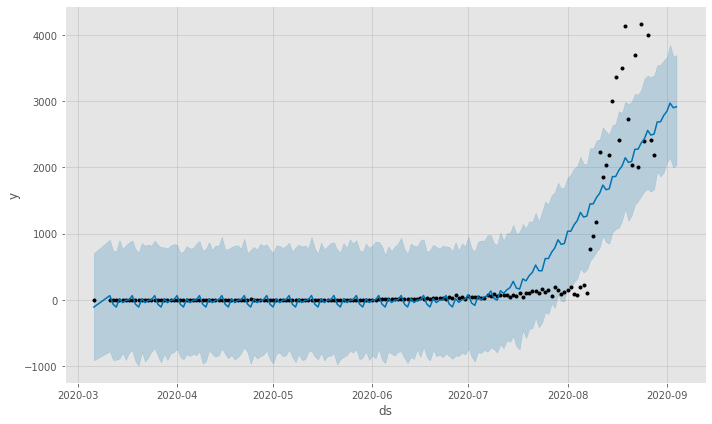

In [ ]:
#---------Recuperados---------------


#recu_bog_forecast_plot = m.plot(forecast)


#----------Casos actuales-----------------


ca_bog_forecast_plot = m.plot(forecast)

#----------Fallecidos-----------------


#fa_bog_forecast_plot = m.plot(forecast)

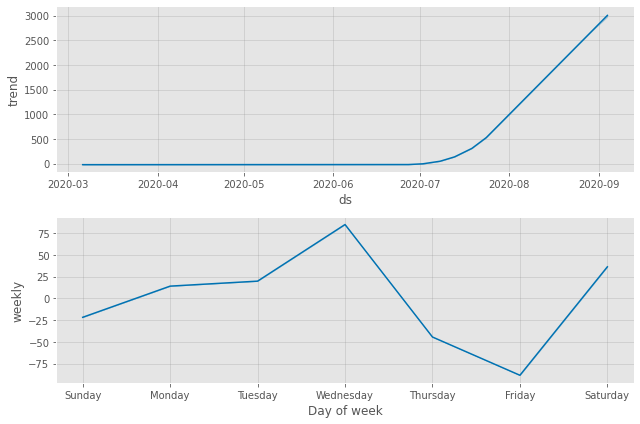

In [ ]:
#------Recuperados--------------------------------


#recu_bog_forecast_plot =m.plot_components(forecast)

#-------Casos actuales---------------------------------

ca_bog_forecast_plot =m.plot_components(forecast)


#-------Fallecidos---------------------------------

#fa_bog_forecast_plot =m.plot_components(forecast)